[View in Colaboratory](https://colab.research.google.com/github/jonghoonseo/handson-ml/blob/wip/11_Training_Deep_Neural_Nets.ipynb)

# Chapter 11. 심층 신경망 훈련

복잡한 문제 해결을 위한 깊은 심층 신경망 훈련의 문제
1. Gradients 문제 - Vanishing Gradients / Exploding Gradients <= 적절한 초기화와 활성화 함수, 배치 정규화
2. 극단적으로 느린 학습 속도 <= 모델 재사용, 학습 동결, 캐싱
3. Overfitting <= 규제

In [0]:
### 재실행! ###

# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력 - Colab 에서 설정하는 방법 찾아야 함.
def get_osx_hangul_font():
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm

    print ('설정파일 위치: ', mpl.matplotlib_fname())
    # OSX 의 설치 된 폰트를 가져오는 함수
    font_list_mac = fm.OSXInstalledFonts()

    nanum_fonts = [(f.name, f.fname) for f in fm.fontManager.ttflist if 'Myungjo' in f.name]
    print(nanum_fonts)
# plt.rcParams["font.family"] = 'AppleMyungjo'
# # plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

! mkdir -p images/deep

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## 11.1 그래디언트 소실과 폭주 문제

역전파 알고리즘(backpropagation algorithm)
- 출력층에서 입력층으로 오차 그래디언트를 전파시키면서 진행
- 알고리즘이 모든 파라미터에 대한 오차 함수의 그래디언트를 계산하면 Gradients Descent 단계에서 이 그래디언트를 이용하여 파라미터를 갱신함
- 알고리즘이 하위층으로 진행됨에 따라 그래디언트는 점점 작아지는 경우가 많음: **Vanishing Gradients**
![Vanishing Gradient](https://t1.daumcdn.net/cfile/tistory/2738F43B583AC4C933)
- 반대로 그래디언트가 점점 커져 여러개의 층이 비정상적으로 큰 가중치로 갱신되어 발산: **Exploding Gradients** (RNN 에서 주로 나타남)

##### Understanding the difficulty of training deep feedforward neural networks
> Glorot, Xavier, and Yoshua Bengio. "**Understanding the difficulty of training deep feedforward neural networks.**" In Proceedings of the thirteenth international conference on artificial intelligence and statistics, pp. 249-256. 2010.

- 로지스틱 시그모이드 활성화 함수
- 가중치 초기화 방법
  - 평균이 0, 표준편차가 1인 정규분포를 사용한 무작위 초기화
- 이 조합으로 학습했을 때, **출력**의 분산이 **입력**의 분산보다 더 큼
- 신경망의 위쪽으로 갈수록 분산이 계속 커져 가장 높은층에서는 Activation Function 이 **0이나 1**로 수렴함
![LogisticActivation](https://github.com/jonghoonseo/handson-ml/blob/wip/images/deep/sigmoid_saturation_plot.png?raw=1)
    - 로지스틱 함수의 **평균**이 0이 아니라 **0.5**
    - 하이퍼볼릭 탄젠트는 평균이 0이므로 조금 더 나음
    - 입력의 절대값이 크면 0이나 1로 수렴 => 기울기가 0에 매우 가까움 => backpropagation 시 propagate 할 그래디언트가 거의 없고, 최상위층부터 backpropagate 되면서 점차 약해져 실제로 아래쪽 층에는 아무것도 도달하지 않음
    - 로지스틱 함수의 도함수는 $\sigma(1-\sigma)$ 이므로, 함수의 값이 0이나 1에 가까우면 도함수의 결과가 매우 작아지고, 층이 거듭될수록 그 값이 더 작아짐
    

Mean:  0.5000000000000002


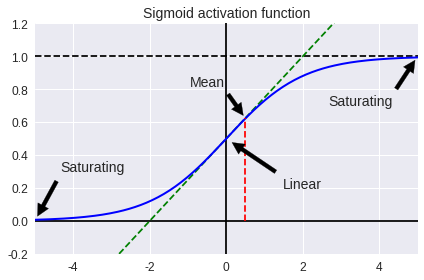

In [90]:
def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)
logit_z = logit(z)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)

props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")

# print mean
mean = sum(logit_z) / len(logit_z)
print('Mean: ', mean)
plt.plot([mean, mean], [0, logit(mean)], 'r--')
plt.annotate('Mean', xytext=(mean-1, logit(mean+1)), xy=(mean,logit(mean)), arrowprops=props, fontsize=14, ha="center")

plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

### 11.1.1 Xavier 초기화와 He 초기화

- 예측을 할 때는 정방향으로,<br/>
역전파할 때는 역방향으로 신호가 적절하게 흘러야 함
- 신호가 죽거나 폭주/소멸하지 않아야 함
- **각 층의 출력에 대한 분산이 입력에 대한 분산과 동일해야 함!**

----
**식 11-1: Xavier 초기화 (로지스틱 활성화 함수를 사용했을 때)**

> $
\begin{split}
& \text{평균이 0이고 표준 편차 }
\sigma = \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} \text{ 인 정규분포}\\
& \text{또는 }
r = \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} \text{ 일 때 } -r \text{ 과 } +r \text{ 사이의 균등분포}
\end{split}
$

단, $n_\text{inputs}$와 $n_\text{outputs}$는 가중치를 초기화하려는 층의 입력/출력 연결의 개수 (fan-in/out)

----

**입력의 개수와 출력의 개수가 비슷하면($n_\text{inputs} \approx n_\text{outputs}$) 더 간단한 공식 사용 가능**

> 예를 들면, $ \sigma = \dfrac{1}{\sqrt{n_\text{inputs}}} $ 또는 $ r = \dfrac{\sqrt{3}}{\sqrt{n_\text{inputs}}} $

----

**He initialization**: ReLU 활성화 함수 및 변종들을 위한 초기화 variance_scaling_initializer전략

----

**표 11-1: 활성화 함수 종류에 따른 초기화 매개변수**

| Activation Func. | Uniform Distribution________ | Normal Distribution________ |
|--------------|-------------------|-----------------------------------|
| Logistic | $ r = \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $ | $ \sigma = \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $ |
| Hyperbolic tangent | $ r = 4 \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $ | $ \sigma = 4 \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $ |
| ReLU (and its variants) |$ r = \sqrt{2} \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $ | $ \sigma = \sqrt{2} \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $|

`tf.layer.dense()` 함수는 기본적으로 **Xavier 초기화(with uniform distribution)** 을 사용함 이를 `tf.variance_scaling_initializer()` 함수를 이용하여 아래와 같이 변경 가능
>```
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")
```

In [0]:
### 재실행! ###
import tensorflow as tf

In [0]:
### 재실행! ###
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

he_init = tf.variance_scaling_initializer()
# ReLU 활성화 함수, He 초기화
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

### 11.1.2 수렴하지 않는 활성화 함수 (Nonsaturating Activation Functions)

- (Glorot & Bengio, 2010)의 insight 중 하나는, "**활성화 함수를 잘못 선택하면 그래디언트의 소실이나 폭주로 이어질 수 있다**"는 것
  - 그 전에는 생물학적 뉴런과 유사한 Sigmoid 함수가 최선의 선택일 것이라고 추측
- ReLU
  - 특정 양숫값에 수렴하지 않을 뿐 아니라, 계산도 빠르다는 장점
  - 하지만... *dying ReLUs problem*
    - 훈련하는 동안 일부 뉴런이 0 이외의 값을 출력하지 않음
    - 큰 학습률을 사용하면 뉴런 절반이 죽어있기도 함
    - 학습 도중 가중치가 바뀌어 가중치 합이 음수가 되면, 그 다음부터는 0을 출력함 - 다시 살아나지 못함...
- **LeakyReLU(새는 ReLU)**
  - dying ReLUs 문제 해결
  - $LeakyReLU_\alpha(z) = max(\alpha z,z)$
  ![LeakyReLU](https://github.com/jonghoonseo/handson-ml/blob/wip/images/deep/leaky_relu_plot.png?raw=1)
  - $\alpha$
    - 새는 정도(how much the function 'leaks')를 나타냄
    - $z<0$일 때 이 함수의 기울기
    - 일반적으로 $0.01$ <br/>
      $0.2$ 가 더 나은 성능을 내는 것으로 보임
    - ReLU가 절대 죽지 않고 다시 깨어날 가능성 부여
  - (Xu, Wang, Chen, & Li, 2015)
    - **LeakyReLU 가 항상 ReLU보다 성능이 높음**
    - RReLU (Randomized leaky ReLU)
      - 학습 시에는 범위 내에서 $\alpha$를 무작위로 선택하고, 테스트 시에는 평균 사용
      - 잘 동작했으며, overfitting 을 줄이는 Regulation 의 역할
    - PReLU (Parametric leaky ReLU)
      - 훈련 동안 $\alpha$가 학습됨 (하이퍼파라미터가 아니라 역전파에 의해 변경됨)
      - 대규모 이미지 데이터셋에서는 ReLU보다 성능이 앞서지만, 소규모 데이터셋에서는 overfitting 될 위험
          

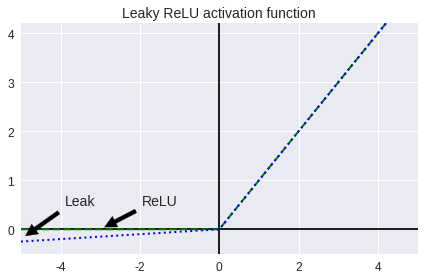

In [93]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.plot(z, leaky_relu(z, 0), "g--", linewidth=2)
plt.plot(z, leaky_relu(z, 0.05), "b:", linewidth=2)
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('ReLU', xytext=(-1.5, 0.5), xy=(-3, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

#### Leaky ReLU를 이용한 tensorflow 학습

In [0]:
### 재실행! ###
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

# LeakyReLU 정의 - tf 1.4 에 추가됨 tf.nn.leaky_relu()
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

# define network
with tf.name_scope("dnn"):
    # 28*28 -> 300 (leaky_relu)
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    # 300 -> 100 (leaky_relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    # 100 -> 10
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

# loss
# https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/tutorials/mnist/tf/
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.01

# train
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
# evaluation
with tf.name_scope("eval"):
    # in_top_k(predictions, targets, k, name=None): Says whether the targets are in the top K predictions.
    correct = tf.nn.in_top_k(logits, y, 1)   # tf.argmax(logits)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

데이터 로드:

주의: `tf.examples.tutorials.mnist`은 삭제될 예정이므로 대신 `tf.keras.datasets.mnist`를 사용하겠습니다.

In [0]:
### 재실행! ###
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [96]:
### 재실행! ###
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 배치 데이터 정확도: 0.86 검증 세트 정확도: 0.9044
5 배치 데이터 정확도: 0.94 검증 세트 정확도: 0.9494
10 배치 데이터 정확도: 0.92 검증 세트 정확도: 0.9652
15 배치 데이터 정확도: 0.94 검증 세트 정확도: 0.9712
20 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9764
25 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9776
30 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9782
35 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9786


**ELU (Exponential Linear Unit)**
- (Clevert, Unterthiner, & Hochreiter, 2015)
- 다른 모든 ReLU 변종의 성능을 앞지름
- 학습 시간 감소
- **식 11-2: ELU 활성화 함수**
>$
\operatorname{ELU}_\alpha(z) =
\begin{cases}
\alpha(\exp(z) - 1) & z < 0 \text{ 일 때}\\
z & z \ge 0 \text{ 일 때}
\end{cases}
$

단, $\alpha$ 는 $z$가 큰 음숫값일 때, ELU 가 수렴할 값. 보통 1로 설정

<!-- ![ELU activation function](./images/deep/elu_plot.png) -->

- ReLU 와의 차이점
  1. $z < 0$ 일 때, 음수가 들어오므로, 평균 출력이 0에 더 가까움 -> Vanishing Gradients 문제를 완화해 줌. 
  2. $z < 0$ 이라도, 그래디언트가 0이 아니므로 죽은 뉴런을 만들지 않음
  3. $\alpha = 1$일 때, $z = 0$에서 급격히 변동하지 않고, $z = 0$을 포함해 모든 구간에서 매끄러우므로, 경사하강법의 속도를 높임 (ELU의 도함수는 $z<0$일 때, $\alpha(z)$이고, $z \geq 0$ 일 때, 1 이므로, $\alpha \neq 1$인 경우 $z = 0$에서 불연속)
  
- ELU의 단점
  - 지수함수를 사용하기 때문에 계산이 느림
  - 학습 동안에는 수렴 속도가 빠르므로 상쇄되나, <br/>
    테스트 시에는 ReLU보다 느림

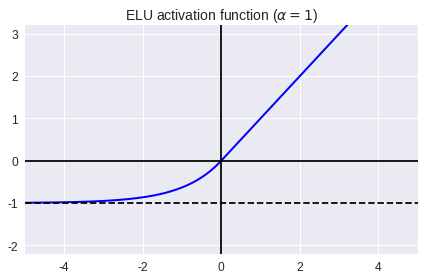

In [97]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

텐서플로에서 ELU를 구현하는 것은 간단합니다. 층을 구성할 때 활성화 함수에 지정하기만 하면 됩니다:

In [0]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

# ELU 로 활성화: activation=tf.nn.elu
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

#### 정리 - 어떤 활성화 함수를 선택할 것인가?

| Case | Activation Function |
|-----|-------|
| 일반적|  ELU > LeakyReLU(and variants) > ReLU > tanh > Logistic |
| 실행 속도(Runtime Performance)가 중요 | LeakyReLU > ELU |
| Overfitting 되었다면 | RReLU |
| Training Set 이 아주 크다면 | PReLU |
| 2017년 10월 구글 브레인팀 (Ramachandran, Zoph, & Le, 2018) | Swish $\text{Swish}(z) = z \text{sigmoid}(z)$ |

이 경우, **He 초기화** 사용


#### References

(Clevert, Unterthiner, & Hochreiter, 2015) Clevert, D.-A., Unterthiner, T., & Hochreiter, S. (2015). Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUs). ArXiv:1511.07289 [Cs]. Retrieved from http://arxiv.org/abs/1511.07289

(Glorot & Bengio, 2010) Glorot, X., & Bengio, Y. (2010). Understanding the difficulty of training deep feedforward neural networks. In In Proceedings of the International Conference on Artificial Intelligence and Statistics (AISTATS’10). Society for Artificial Intelligence and Statistics.

(Ramachandran, Zoph, & Le, 2018) Ramachandran, P., Zoph, B., & Le, Q. (2018). Searching for Activation Functions. Retrieved from https://arxiv.org/pdf/1710.05941.pdf

(Xu, Wang, Chen, & Li, 2015) Xu, B., Wang, N., Chen, T., & Li, M. (2015). Empirical Evaluation of Rectified Activations in Convolutional Network. ArXiv:1505.00853 [Cs, Stat]. Retrieved from http://arxiv.org/abs/1505.00853


https://pozalabs.github.io/Activation_Function/


### 11.1.3 배치 정규화 (Batch Normalization)

ReLU variation + He Initialization => 학습 초기 단계에서 그래디언트 문제 해결. but, 훈련하는 동안 재발생 가능

#### BN (Batch Normalization)
- (Ioffe & Szegedy, 2015)
- Goal
  - 불안정한 그래디언트 문제 해결
  - 더 일반적으로, **내부 공변량 변화(Internal Covariate Shift)** 문제 - 훈련하는 동안 이전 층의 파라미터가 변함에 따라 각 층에 들어오는 입력의 분포가 변화되는 문제 해결
- 연산
  - 각 층에서 활성화 함수를 통과하기 전에 모델에 연산을 하나 추가
  - **입력 데이터의 평균을 0으로** 만들고 정규화한 다음, 각 층에서 두 개의 새로운 파라미터로 결괏값의 스케일을 조정하고 이동시킴.
  - 파라미터 1: 스케일 조정 <br/>
    파라미터 2: 이동
  - 모델이 층마다 입력 데이터의 최적 스케일과 평균을 학습함.
  - 현재 미니배치에서 입력의 평균과 표준편차를 평가함.
  - **Equation 11-3: 배치 정규화 알고리즘**
$$
\begin{split}
1.\quad & \mathbf{\mu}_B = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}{\mathbf{x}^{(i)}}\\
2.\quad & {\mathbf{\sigma}_B}^2 = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}{(\mathbf{x}^{(i)} - \mathbf{\mu}_B)^2}\\
3.\quad & \hat{\mathbf{x}}^{(i)} = \dfrac{\mathbf{x}^{(i)} - \mathbf{\mu}_B}{\sqrt{{\mathbf{\sigma}_B}^2 + \epsilon}}\\
4.\quad & \mathbf{z}^{(i)} = \gamma \hat{\mathbf{x}}^{(i)} + \beta
\end{split}
$$
    - $\mathbf{\mu}_B$: 미니배치 $B$에 대해 평가하여 관측한 평균
    - $\mathbf{\sigma}_B$: 미니배치 $B$에 대해 평가하여 관측한 표준편차
    - $m_B$: 미니배치에 있는 샘플 수
    - $\hat{\mathbf{x}}^{(i)}$: 평균이 0이고, 정규화된 입력
    - $\gamma$: 스케일 파라미터
    - $\beta$: 이동(편향) 파라미터
    - $\epsilon$: 분모가 0이 되는 것을 막는 작은 숫자 (안전을 위한 항 smoothing term)
    - $\mathbf{z}^{(i)}$: BN연산의 출력. 스케일 조정하고, 이동시킨 결과
    
  - **테스트 시** 에는 미니배치가 없으므로, 전체 훈련 세트의 평균과 표준편차를 대신 사용
  - BN 층마다 $\gamma$(스케일), $\beta$(이동), $\mu$(평균), $\sigma$(표준편차) 네 개의 파라미터가 학습됨
- 효과
  - 성능 향상.
  - tanh이나 로지스틱 활성화 함수 같이 수렴되는 활성화 함수를 사용해도 그래디언트 소실 문제가 크게 감소됨
  - 가중치 초기화에 덜 민감해짐
  - 큰 학습률을 사용할 수 있어, 학습 속도를 크게 개선
  - overfitting 개선: 규제(Regularation)와 같은 역할을 하여, 다른 규제 기법의 필요성 줄여줌.(부수효과이므로, 드롭아웃을 함께 사용하는 것이 좋음)
  
- 한계
  - 모델의 복잡도 증가
  - 예측 속도 저하
    - 예측이 매우 빨라야 한다면, ELU+He 초기화 만으로 얼마나 잘 수행되는지 먼저 확인
  
    

#### 텐서플로로 배치 정규화 구현

1. `tf.nn.batch_normalization()`
  - 평균과 표준편차를 직접 계산해 매개변수로 전달해야 함.
  - 스케일 조정과 이동을 위한 파라미터를 직접 생성하고 전달해야 함.
2. `tf.layers.batch_normalization()`
  - 사용이 편리

In [0]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

# training: True, validation/testing: False
training = tf.placeholder_with_default(False, shape=(), name='training')

# Fully Connected Layer 1: 28*28 -> 300 / 활성화 함수 없음!!!
hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
# Batch Normalization Layer 1: 300 -> 300
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

- `tf.placeholder_with_default`: training 여부에 따라 True / False 가짐. 13째 줄의 False 는 default value
- fully connected layer 와 batch layer 가 번갈아 나옴
- batch layer 이후에 activation function 을 사용하므로, fully connected layer 에서는 활성화 함수 없음.
  - 하지만, 연구자에 따라 activation function 이후에 BN 수행하는 것이 좋다는 의견도 있음
- BN알고리즘은 **지수 감수(exponential decay)** 를 사용해 이동 평균 계산
  - 이동 평균 $\hat{v}$은 아래와 같이 갱신됨 <br/>
  $ \hat{v} \gets \hat{v} \times \text{momentum} + v \times (1 - \text{momentum}) $
  - 적절한 모멘텀 값은 일반적으로 1에 가까움
  - 데이터셋이 크고 미니 배치가 작을 경우 9를 더 넣어 1에 더 가깝게 함
  

In [0]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')


# functools.partial 이용하여 중복 매개변수 제거
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

각 층에 ELU 활성화 함수와 배치 정규화를 사용하여 MNIST를 위한 신경망을 만듭니다:

In [0]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')
# training = tf.placeholder(tf.bool, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

노트: 배치 정규화를 위해 별도의 업데이트 연산을 실행해 주어야 합니다(`sess.run([training_op, extra_update_ops],...`).

In [102]:
n_epochs = 20
batch_size = 200

# moving_mean과 moving_variance를 업데이트
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            # Batch Normalization 을 위해 수정
            # training_op 와 extra_update_ops 계산
            # 학습 과정이므로, training은 True 로 설정
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={training: False, X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_BN_model_final.ckpt")

0 검증 세트 정확도: 0.8952
1 검증 세트 정확도: 0.9202
2 검증 세트 정확도: 0.9318
3 검증 세트 정확도: 0.9422
4 검증 세트 정확도: 0.9468
5 검증 세트 정확도: 0.954
6 검증 세트 정확도: 0.9568
7 검증 세트 정확도: 0.96
8 검증 세트 정확도: 0.962
9 검증 세트 정확도: 0.9638
10 검증 세트 정확도: 0.9662
11 검증 세트 정확도: 0.9682
12 검증 세트 정확도: 0.9672
13 검증 세트 정확도: 0.9696
14 검증 세트 정확도: 0.9706
15 검증 세트 정확도: 0.9704
16 검증 세트 정확도: 0.9718
17 검증 세트 정확도: 0.9726
18 검증 세트 정확도: 0.9738
19 검증 세트 정확도: 0.9742


훈련을 더 오래하면 정확도가 높아지겠지만 이런 얕은 신경망에서는 배치 정규화와 ELU가 큰 효과를 내지 못합니다. 대부분 심층 신경망에서 빛을 발합니다.

#### References

(Ioffe & Szegedy, 2015) Ioffe, S., & Szegedy, C. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. Retrieved from https://arxiv.org/abs/1502.03167


### 11.1.4 그래디언트 클리핑

- Exploding Gradients 문제 해결
- Backpropagation 시 일정 임계값을 넘어서지 못하게 그냥 단순히 잘라냄
- RNN 에서 일반적으로 널리 사용됨
- 적용
  - 일반적인 최적화: `minimize()` 함수 사용 -> 그래디언트 계산과 적용 모두 처리
  - 이를 `compute_gradients()` 와 `apply_gradients()` 로 분리하고, 그 사이에 `clip_by_value()` 함수를 적용하여 그래디언트를 클리핑함
  


In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [0]:
learning_rate = 0.01

threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
# 그래디언트 계산
grads_and_vars = optimizer.compute_gradients(loss)
# 그래디언트 클리핑
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
# 그래디언트 적용
training_op = optimizer.apply_gradients(capped_gvs)

나머지는 동일

In [105]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_gradients_clipping_final.ckpt")
    
! ls ./my_model_gradients_clipping_final*

0 검증 세트 정확도: 0.2876
1 검증 세트 정확도: 0.7944
2 검증 세트 정확도: 0.8794
3 검증 세트 정확도: 0.9062
4 검증 세트 정확도: 0.9162
5 검증 세트 정확도: 0.9218
6 검증 세트 정확도: 0.9296
7 검증 세트 정확도: 0.9354
8 검증 세트 정확도: 0.9382
9 검증 세트 정확도: 0.9416
10 검증 세트 정확도: 0.9456
11 검증 세트 정확도: 0.947
12 검증 세트 정확도: 0.9476
13 검증 세트 정확도: 0.953
14 검증 세트 정확도: 0.9564
15 검증 세트 정확도: 0.9566
16 검증 세트 정확도: 0.9578
17 검증 세트 정확도: 0.9586
18 검증 세트 정확도: 0.9626
19 검증 세트 정확도: 0.9612
./my_model_gradients_clipping_final.ckpt.data-00000-of-00001
./my_model_gradients_clipping_final.ckpt.index
./my_model_gradients_clipping_final.ckpt.meta


## 11.2 미리 훈련된 층 재사용하기

**Transfer learning**
- 해결하려는 것과 비슷한 유형의 문제를 처리한 신경망이 이미 있는지 찾아보고 그런 다음 그 신경망의 하위층을 재사용하는 것이 좋음
- 장점
  - 훈련 속도를 크게 높여줌
  - 필요한 훈련 데이터도 훨씬 적음
- 원래 문제와 다른 크기의 이미지를 입력으로 사용한다면 원본 모델에 맞는 크기로 변경하는 전처리 필요함
- 입력이 비슷한 저수준 특성을 가질 때 효과적
  
  ![fig_11_4](https://github.com/jonghoonseo/handson-ml/raw/wip/images/deep/fig_11_4.png)

### 11.2.1 텐서플로 모델 재사용하기

먼저 그래프 구조를 로드해야 합니다. `import_meta_graph()` 함수가 그래프 연산들을 로드하여 기본 그래프에 적재하고 모델의 상태를 복원할 수 있도록 `Saver` 객체를 반환합니다. 기본적으로 `Saver` 객체는 `.meta` 확장자를 가진 파일에 그래프 구조를 저장하므로 이 파일을 로드해야 합니다:

In [106]:
reset_graph()

! ls *.meta
saver = tf.train.import_meta_graph("./my_model_gradients_clipping_final.ckpt.meta")

my_BN_model_final.ckpt.meta
my_model_dropout_final.ckpt.meta
my_model_final.ckpt.meta
my_model_gradients_clipping_final.ckpt.meta
my_model_max_norm2_final.ckpt.meta
my_model_max_norm_final.ckpt.meta
my_model_regularization2_final.ckpt.meta
my_model_regulation_final.ckpt.meta
my_new_model_caching_final.ckpt.meta
my_new_model_final.ckpt.meta
my_new_model_frozen_1_final.ckpt.meta
my_new_model_frozen_2_final.ckpt.meta
my_new_model_gradients_clipping_final_import_meta_graph.ckpt.meta
my_new_model_gradients_clipping_final_Saver.ckpt.meta


다음으로 훈련해야 할 모든 연산을 가져와야 합니다. 그래프 구조를 모를 때는 모든 연산을 출력해 볼 수 있습니다:

In [107]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

너무 많으면 tensorboard 이용

In [108]:
! rm tensorflow_graph_in_jupyter.py* wget-log*
! wget https://github.com/rickiepark/handson-ml/raw/master/tensorflow_graph_in_jupyter.py
! ls

from tensorflow_graph_in_jupyter import show_graph

show_graph(tf.get_default_graph())

rm: cannot remove 'wget-log*': No such file or directory
--2018-10-12 16:07:20--  https://github.com/rickiepark/handson-ml/raw/master/tensorflow_graph_in_jupyter.py
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/handson-ml/master/tensorflow_graph_in_jupyter.py [following]
--2018-10-12 16:07:20--  https://raw.githubusercontent.com/rickiepark/handson-ml/master/tensorflow_graph_in_jupyter.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2159 (2.1K) [text/plain]
Saving to: ‘tensorflow_graph_in_jupyter.py’

tensorflow_graph_in 100%[===================>]   2.11K  --.-KB/s 

필요한 연산을 찾았다면 그래프의 `get_operation_by_name()`이나 `get_tensor_by_name()` 메서드를 사용하여 추출할 수 있습니다:

In [0]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

재사용성 높이기
1. 연산에 명확한 이름 부여
2. 문서화
3. **중요한 연산들을 모아놓은 컬렉션 만들기**

In [0]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

컬렉션 재사용 시

In [0]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

**1. 세션을 시작**하고 **2. 모델을 복원**하여 **3. 준비된 훈련 데이터로 훈련을 계속**할 수 있습니다:

In [112]:
! ls

with tf.Session() as sess:
    saver.restore(sess, "my_model_gradients_clipping_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

checkpoint
images
my_BN_model_final.ckpt.data-00000-of-00001
my_BN_model_final.ckpt.index
my_BN_model_final.ckpt.meta
my_model_dropout_final.ckpt.data-00000-of-00001
my_model_dropout_final.ckpt.index
my_model_dropout_final.ckpt.meta
my_model_final.ckpt.data-00000-of-00001
my_model_final.ckpt.index
my_model_final.ckpt.meta
my_model_gradients_clipping_final.ckpt.data-00000-of-00001
my_model_gradients_clipping_final.ckpt.index
my_model_gradients_clipping_final.ckpt.meta
my_model_max_norm2_final.ckpt.data-00000-of-00001
my_model_max_norm2_final.ckpt.index
my_model_max_norm2_final.ckpt.meta
my_model_max_norm_final.ckpt.data-00000-of-00001
my_model_max_norm_final.ckpt.index
my_model_max_norm_final.ckpt.meta
my_model_regularization2_final.ckpt.data-00000-of-00001
my_model_regularization2_final.ckpt.index
my_model_regularization2_final.ckpt.meta
my_model_regulation_final.ckpt.data-00000-of-00001
my_model_regulation_final.ckpt.index
my_model_regulation_final.ckpt.meta
my_new_model_caching_final

다른 방법:
- 원본 그래프를 만든 파이썬 코드에 접근 가능할 때 `import_meta_graph()` 사용

In [0]:
# 원본 그래프를 만든 파이썬 코드

reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [114]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_gradients_clipping_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_gradients_clipping_final.ckpt
0 검증 세트 정확도: 0.9636
1 검증 세트 정확도: 0.9624
2 검증 세트 정확도: 0.9652
3 검증 세트 정확도: 0.9654
4 검증 세트 정확도: 0.9642
5 검증 세트 정확도: 0.965
6 검증 세트 정확도: 0.9686
7 검증 세트 정확도: 0.9682
8 검증 세트 정확도: 0.968
9 검증 세트 정확도: 0.9686
10 검증 세트 정확도: 0.9704
11 검증 세트 정확도: 0.9716
12 검증 세트 정확도: 0.9672
13 검증 세트 정확도: 0.9702
14 검증 세트 정확도: 0.9708
15 검증 세트 정확도: 0.9724
16 검증 세트 정확도: 0.9718
17 검증 세트 정확도: 0.971
18 검증 세트 정확도: 0.9712
19 검증 세트 정확도: 0.9712


하위층만 재사용

- `import_meta_graph()`를 사용하면 전체 그래프를 로드하지만 필요하지 않은 부분은 무시
- 이 예에서는 학습된 3번째 층 위에 4번째 은닉층을 새로 추가(원래 4번째 층은 무시)


In [0]:
reset_graph()

n_hidden4 = 20  # 새 층
n_outputs = 10  # 새 층

# import_meta_graph() 사용한 복원 - 전체 그래프 로드
saver = tf.train.import_meta_graph("./my_model_gradients_clipping_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0") # 기존 층

# 새 층
new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

새로운 모델을 훈련

In [116]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_gradients_clipping_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_gradients_clipping_final_import_meta_graph.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_gradients_clipping_final.ckpt
0 검증 세트 정확도: 0.9122
1 검증 세트 정확도: 0.9376
2 검증 세트 정확도: 0.946
3 검증 세트 정확도: 0.9502
4 검증 세트 정확도: 0.953
5 검증 세트 정확도: 0.9524
6 검증 세트 정확도: 0.9566
7 검증 세트 정확도: 0.96
8 검증 세트 정확도: 0.9616
9 검증 세트 정확도: 0.961
10 검증 세트 정확도: 0.9632
11 검증 세트 정확도: 0.9626
12 검증 세트 정확도: 0.9648
13 검증 세트 정확도: 0.9656
14 검증 세트 정확도: 0.9662
15 검증 세트 정확도: 0.967
16 검증 세트 정확도: 0.9678
17 검증 세트 정확도: 0.9676
18 검증 세트 정확도: 0.9684
19 검증 세트 정확도: 0.9678


원본 모델 코드에 접근 가능하다면 필요한 부분만 재사용 가능

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # 재사용
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

2개의 `Saver()` 객체 생성 - 하나는 복원, 하나는 저장을 위한 객체

복원
- 가져오고자 하는 층을 `get_collection()` 에서 `scope`을 정규표현식을 이용하여 정의하고
- `tf.train.Saver()`로 복원

In [118]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규표현식
# 1~3층 복원을 위한 Saver() 객체
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
# 저장을 위한 Saver() 객체
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_gradients_clipping_final.ckpt")

    for epoch in range(n_epochs):                                        # 책에는 없음
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # 책에는 없음
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})    # 책에는 없음
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # 책에는 없음
        print(epoch, "검증 세트 정확도:", accuracy_val)                      # 책에는 없음

    save_path = saver.save(sess, "./my_new_model_gradients_clipping_final_Saver.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_gradients_clipping_final.ckpt
0 검증 세트 정확도: 0.9018
1 검증 세트 정확도: 0.933
2 검증 세트 정확도: 0.9428
3 검증 세트 정확도: 0.947
4 검증 세트 정확도: 0.9518
5 검증 세트 정확도: 0.9536
6 검증 세트 정확도: 0.9556
7 검증 세트 정확도: 0.959
8 검증 세트 정확도: 0.9586
9 검증 세트 정확도: 0.9606
10 검증 세트 정확도: 0.9624
11 검증 세트 정확도: 0.962
12 검증 세트 정확도: 0.9642
13 검증 세트 정확도: 0.9664
14 검증 세트 정확도: 0.9662
15 검증 세트 정확도: 0.9664
16 검증 세트 정확도: 0.967
17 검증 세트 정확도: 0.9674
18 검증 세트 정확도: 0.968
19 검증 세트 정확도: 0.9674


### 11.2.2 다른 프레임워크의 모델 재사용하기

만약 모델이 다른 프레임워크로 훈련되어 있다면 수동으로 모델 파라미터를 읽어 적절한 변수에 할당해야 함.

모든 텐서플로 변수(`v`)는 아래 3개의 연산 노드를 가짐
- 값을 읽는 연산: `v/read`
- 값을 초기화 하는 연산: `v/initial_value`
- 값을 할당하는 연산: `v/Assign`
  - 변수 `v`의 할당 연산 `v/Assign`의 첫번째 입력은 변수 자체(`v`)고,<br/>
    두번째 연산은 변수에 할당될 값(`v/initial_value`)임.
  - 할당 연산의 두번째 입력(`[1]`)에 초깃값을 주입


In [119]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # 다른 프레임워크로부터 가중치를 로드
original_b = [7., 8., 9.]                 # 다른 프레임워크로부터 편향을 로드

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] 모델의 나머지 부분을 구성

# hidden1 변수의 할당 노드에 대한 핸들을 구합니다
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
### 할당 연산의 두번째 입력
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    ### feed_dict 를 이용하여 새로운 값을 주입함
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] 새 작업에 모델을 훈련시킵니다
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # 책에는 없음

[[ 61.  83. 105.]]


### 11.2.3 신경망의 하위층을 학습에서 제외하기

DNN 의 하위층은 이미지의 저수준 특징을 감지하므로, 다른 이미지 분류 작업에 유용함

이 층들은 있는 그대로 재사용할 수 있음

일반적으로 새로운 DNN을 훈련시킬 때 재사용되는 층들의 가중치는 **'동결'** 하는 것이 좋음
(이렇게 학습되지 않는 층을 **Frozen Layer** 라고 함)


#### 학습 과정에서 하위층 고정하는 방법
1. 하위층의 변수를 제외하고 훈련시킬 변수 목록을 옵티마이저에 전달


In [120]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # 재사용
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):                                         # 책에는 없음
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # 책에는 없음
    
    ### 학습하려는 변수 범위만 `scope`으로 필터링
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    ### 이렇게 필터된 리스트만 `var_list`에 추가
    training_op = optimizer.minimize(loss, var_list=train_vars)
    
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_gradients_clipping_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_frozen_1_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_gradients_clipping_final.ckpt
0 검증 세트 정확도: 0.8962
1 검증 세트 정확도: 0.9292
2 검증 세트 정확도: 0.9396
3 검증 세트 정확도: 0.9442
4 검증 세트 정확도: 0.9482
5 검증 세트 정확도: 0.9506
6 검증 세트 정확도: 0.9506
7 검증 세트 정확도: 0.9536
8 검증 세트 정확도: 0.9554
9 검증 세트 정확도: 0.9566
10 검증 세트 정확도: 0.9562
11 검증 세트 정확도: 0.9564
12 검증 세트 정확도: 0.9566
13 검증 세트 정확도: 0.9578
14 검증 세트 정확도: 0.9592
15 검증 세트 정확도: 0.9574
16 검증 세트 정확도: 0.9574
17 검증 세트 정확도: 0.9598
18 검증 세트 정확도: 0.959
19 검증 세트 정확도: 0.9602


2. 그래프에 `stop_gradient()` 층 추가. 이 아래 모든 층이 동결됨


In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # 동결층 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # 동결층 재사용
    ### stop_gradient()로 동결하고자 하는 층 정의
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # 동결하지 않고 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # 새로 만듦!

In [123]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_gradients_clipping_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_frozen_2_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_gradients_clipping_final.ckpt
0 검증 세트 정확도: 0.9016
1 검증 세트 정확도: 0.931
2 검증 세트 정확도: 0.9434
3 검증 세트 정확도: 0.9476
4 검증 세트 정확도: 0.952
5 검증 세트 정확도: 0.9524
6 검증 세트 정확도: 0.9524
7 검증 세트 정확도: 0.9556
8 검증 세트 정확도: 0.9554
9 검증 세트 정확도: 0.9558
10 검증 세트 정확도: 0.9572
11 검증 세트 정확도: 0.955
12 검증 세트 정확도: 0.9572
13 검증 세트 정확도: 0.9578
14 검증 세트 정확도: 0.9586
15 검증 세트 정확도: 0.9578
16 검증 세트 정확도: 0.9564
17 검증 세트 정확도: 0.9576
18 검증 세트 정확도: 0.9594
19 검증 세트 정확도: 0.9586


### 11.2.4 동결된 층 캐싱하기

동결된 층은 변하지 않기 때문에 각 훈련 샘플에 대해 가장 윗쪽의 동결된 층에서 나온 출력은 캐싱하는 것이 가능
(5 층 중 1~2 층이 동결되었다면, 2층의 데이터를 캐싱)

전체 훈련 세트에 대해 하위층을 먼저 실행한 후, 훈련 샘플($\text{layer}_0$)을 이용한 배치를 만드는 것이 아니라, 은닉층 2($\text{layer}_2$)의 출력을 배치로 만들어 훈련 연산에 주입

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # 재사용
n_hidden2 = 50  # 재사용
n_hidden3 = 50  # 재사용
n_hidden4 = 20  # 새로 만듦!
n_outputs = 10  # 새로 만듦!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # 동결층 재사용
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # 동결층 재사용 & 캐싱
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # 동결하지 않고 재사용
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # 새로 만듦!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # 새로 만듦!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [0]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # 정규 표현식
restore_saver = tf.train.Saver(reuse_vars) # 1-3층 복원

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [126]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_gradients_clipping_final.ckpt")
    
    ### hidden2 까지 계산하여 cache로 저장
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) # 책에는 없음

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        
        ### 이미 계산된 hidden2 레이어에서 train 셋만 추출
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            # TODO: hidden2 가 placeholder가 아닌데, feed_dict로 주입이 가능한가?
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # 책에는 없음
                                                y: y_valid})             # 책에는 없음
        print(epoch, "검증 세트 정확도:", accuracy_val)                      # 책에는 없음

    save_path = saver.save(sess, "./my_new_model_caching_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_gradients_clipping_final.ckpt
0 검증 세트 정확도: 0.9016
1 검증 세트 정확도: 0.931
2 검증 세트 정확도: 0.9434
3 검증 세트 정확도: 0.9476
4 검증 세트 정확도: 0.952
5 검증 세트 정확도: 0.9524
6 검증 세트 정확도: 0.9524
7 검증 세트 정확도: 0.9556
8 검증 세트 정확도: 0.9554
9 검증 세트 정확도: 0.9558
10 검증 세트 정확도: 0.9572
11 검증 세트 정확도: 0.955
12 검증 세트 정확도: 0.9572
13 검증 세트 정확도: 0.9578
14 검증 세트 정확도: 0.9584
15 검증 세트 정확도: 0.9578
16 검증 세트 정확도: 0.9564
17 검증 세트 정확도: 0.9576
18 검증 세트 정확도: 0.9594
19 검증 세트 정확도: 0.9584


### 11.2.5 상위층을 변경, 삭제, 대체하기

일반적으로 기존 모델을 재사용하는 경우, 상위층은 재사용이 어려움
- 출력 뉴런 수도 같지 않을 수 있음
- 고수준 특성은 원본 작업에서 유용했던 특성과 다를 가능성이 큼

새로운 모델 학습
1. 먼저 복사한 모든 층을 동결
2. 그 다음 모델을 훈련시키고 얼마나 성능이 나오는지 확인
3. 가장 윗쪽의 은닉층 1~2개의 동결 해제하여 성능 향상 확인
4. 그래도 좋은 성능을 얻을 수 없고 훈련 데이터가 적다면, 가장 윗쪽의 은닉층을 제거하고 1부터 반복

### 11.2.6 모델 저장소

모델을 어디서 찾아야 할까?
1. 자신의 모델 카탈로그
  - 나중에 찾기 쉽도록 잘 정리하자
2. 텐서플로 모델 저장소 (https://github.com/tensorflow/models)
3. 다른 프레임워크 기반 저장소
  - 다양한 딥러닝 프레임워크 간의 모델 변환기: https://goo.gl/CndSsd
  

### 11.2.7 비지도 사전훈련

레이블된 학습 데이터가 많지 않은 문제

1. 더 많은 레이블된 데이터 수집
2. 비지도 사전훈련 (Unsupervised pretraining)
  - RBM (Restricted Boltmann Machines)
  - Auto-encoder
  - 각 층은 훈련된 이전 층의 출력으로 훈련됨 - 훈견 중인 층을 제외하고 다른 모든 층은 동결
  - 이렇게 모든 층이 훈련되면 역전파 알고리즘으로 세밀하게 튜닝
  
  ![fig_11-5](https://github.com/jonghoonseo/handson-ml/raw/wip/images/deep/fig_11_5.png)
  
  

### 11.2.8 보조 작업으로 사전훈련

**레이블된 훈련 데이터를 쉽게 얻거나 생성할 수 있는 보조 작업** 에 첫번째 신경망을 훈련

그리고 이 신경망의 하위층을 실제 작업을 위해 재사용

하위층은 여러 문제에서 공용으로 사용 가능한 저수준 특징을 포함하는 경우가 많으므로, 쉬운 문제로 첫번째 신경망을 훈련하고, 이 산경망의 하위층을 실제 작업에 재사용



## 11.3 고속 옵티마이저

훈련 속도를 높이는 5가지 전략
1. 연결 가중치에 좋은 **초기화 전략** 적용
2. 좋은 **활성화 함수** 사용
3. **배치 정규화** 사용
4. 미리 훈련된 신경망의 일부 **재사용**
5. **더 빠른 옵티마이저** 사용하기
  - Momentum Optimizer
  - Nesterov Accelerated Gradient
  - AdaGrad
  - RMSProp
  - Adam Optimizer
  
  ![optimizer_history](http://intelliz.co.kr/wp-content/uploads/2015/07/333.jpg)

(원본 출처: http://intelliz.co.kr/?p=196)

### 11.3.1 모멘텀 최적화

(원본 출처: https://icim.nims.re.kr/post/easyMath/428)

Gradient Descent Optimizer 보다 개선된 알고리즘으로 이동값에 관성으로 인한 업데이트가 추가된 Optimizer이다. 다음과 같은 Gradient Descent Optimizer의 한계를 개선하는 데 효과가 있는 알고리즘이다.

![limitation_of_GD](https://icim.nims.re.kr/file/70679cf085a049679f03736d7afad264.png)

- global minimum이 아닌 local minimum으로 수렴
- 최솟값을 찾아가는 도중에 미분계수가 0인 지점에서 더 이상 이동하지 않음

![momentum](https://icim.nims.re.kr/file/1e87c8ef4e2649e69752301c385745c7.png)

Gradient Descent Optimize의 이동량은 미분계수에 의해 결정되기 때문에 미분계수가 0이면 더 이상 업데이트가 되지 않는다.

Momentum Optimizer는 다음과 같이 목적함수  $f$ 의 최솟값을 찾는다.

- 초기값 $x_0$ 와 적당한 Learning rate $\alpha$, momentum $\beta$ 설정
- $n \geq 0$ 인 정수에 대해서 $a_{n+1}$ 과 $x_{n+1}$은 아래와 같이 정의
$$a_{n+1} := \beta \cdot a_n + \nabla f(x_n), a_0 := 0 \\
x_{n+1} := x_n - \alpha \cdot a_{n+1}$$
- (책 버전) **식 11-4: 모멘텀 알고리즘**
  1. $\mathbf{m} \gets \beta \mathbf{m} - \eta \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta})$
  2. $\boldsymbol{\theta} \gets \boldsymbol{\theta} + \mathbf{m}$
- 단, $\eta$는 학습률
- momentum $\beta$
  - 일반적인 값: 0.9
  - 0이라면: Gradient Descent Optimizer 와 동일
- 기울기 $\nabla_\theta J(\theta) == \nabla f(x_n) = 0$임에도 $a_n$에 의한 관성효과로 $x_n$은 갱신됨

![problem_at_slope](https://github.com/jonghoonseo/handson-ml/raw/wip/images/deep/fig_4_7.png)

경사 하강법은 입력 스케일이 매우 다르면 골짜기에서 오래 걸리는데 반해, 모멘텀은 매우 빠르게 갱신됨

배치 정규화를 사용하지 않는 신경망에서는 스케일이 매우 다를 수 있음

Local Optima 를 건너뛰도록 하는데에 도움

경사 하강법보다 거의 항상 더 빠름

In [0]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

### 11.3.2 Nesterov Accelerated Gradient(NAG)

Momentum Optimizer의 개선된 알고리즘으로 차이점은 Gradient $\nabla f$ 를  $x_n$ 에서 계산하는 것이 아니라 관성(momentum)에 의해서 이동한  $x_n + \beta \cdot a_n$ 에서 계산하는 것이다. Nesterov Accelerated Gradient 알고리즘은 다음과 같다.

- 초기값 $x_0$와 적당한 Learning rate $\alpha$, momentum $\beta$ 설정
- $n \geq 0$ 인 정수에 대해서 $a_{n+1}$, $x_{n+1}$은 다음과 같음
$$a_{n+1} := \beta \cdot a_n + \nabla f (x_n - \alpha \cdot \beta \cdot a_n)\\
x_{n+1} := x_n - \alpha \cdot a_{n+1}$$
- (책 버전) **식 11-5: 네스테로프 가속 경사 알고리즘**
  1. $\mathbf{m} \gets \beta \mathbf{m} - \eta \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta} + \beta \mathbf{m})$
  2. $\boldsymbol{\theta} \gets \boldsymbol{\theta} + \mathbf{m}$
  
기본 모멘텀 최적화보다 거의 항상 더 빠름

현재 위치가 아니라 모멘텀의 방향으로 조금 앞서서 비용 함수의 그래디언트를 계산

![nesterov](https://github.com/jonghoonseo/handson-ml/raw/wip/images/deep/fig_11_6.png)

In [0]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

### 11.3.3 AdaGrad

![problem_at_slope](https://github.com/jonghoonseo/handson-ml/raw/wip/images/deep/fig_11_7.png)

가장 가파른 차원을 따라 그래디언트 벡터의 스케일을 감소시켜 이 문제를 해결

**식 11-6: AdaGrad 알고리즘**
1. $\mathbf{s} \gets \mathbf{s} + \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta}) \otimes \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta})$
2. $\boldsymbol{\theta} \gets \boldsymbol{\theta} - \eta \, \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta}) \oslash {\sqrt{\mathbf{s} + \epsilon}}$

간단한 2차방정식 문제에 대해서는 잘 작동하나, 너무 일찍 멈춰버리는 경향

학습률이 너무 감소되어 전역 최적점에 도착하기 전에 알고리즘이 완전히 멈춤

따라서, 간단한 작업 이외에는 사용하지 말아야 함

### 11.3.4 RMSProp

AdaGrad 가 너무 빠르게 느려져서 전역 최적점에 수렴하지  못한 문제를 극복

**식 11-7: RMSProp 알고리즘**

1. $\mathbf{s} \gets \beta \mathbf{s} + (1 - \beta ) \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta}) \otimes \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta})$
2. $\boldsymbol{\theta} \gets \boldsymbol{\theta} - \eta \, \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta}) \oslash {\sqrt{\mathbf{s} + \epsilon}}$


### 11.3.5 Adam 최적화

- Adaptive Moment Estimation
- 모멘텀과 RMSProp 의 하이브리드
  - 모멘텀 최적화처럼 지난 그래디언트의 지수 감소 평균(expomential decaying average) 을 따름
  - RMSProp 처럼 지난 그래디언트 제곱의 지수 감소된 평균을 따름
  
**식 11-8: Adam 알고리즘**

1. $\mathbf{m} \gets \beta_1 \mathbf{m} - (1 - \beta_1) \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta})$
2. $\mathbf{s} \gets \beta_2 \mathbf{s} + (1 - \beta_2) \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta}) \otimes \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta})$
3. $\mathbf{m} \gets \left(\dfrac{\mathbf{m}}{1 - {\beta_1}^T}\right)$
4. $\mathbf{s} \gets \left(\dfrac{\mathbf{s}}{1 - {\beta_2}^T}\right)$
5. $\boldsymbol{\theta} \gets \boldsymbol{\theta} + \eta \, \mathbf{m} \oslash {\sqrt{\mathbf{s} + \epsilon}}$

일반적으로 다른 방법보다 빠르고 좋았음


In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

### 11.3.6 학습률 스케쥴링

![learning_rate](https://github.com/jonghoonseo/handson-ml/raw/wip/images/deep/fig_11_8.png)

학습 스케쥴
: 훈련하는 동안 학습률을 감소시키는 전략
초반에는 큰 값으로 크게 이동하고, 나중에는 작은 값으로 미세 조정
- 미리 정의된 개별적인 고정 학습률
  - 예를 들어 처음에 $\eta_0 = 0.1$로 학습률을 지정하고, 50 에포크 후에 $\eta_1 = 0.001$로 바꿈
  - 잘 작동하지만, 적절한 학습률과 적당한 시점을 찾으려면 이리저리 바꿔봐야 함
  - `piecewise_contant()` 사용
- 성능 기반 스케쥴링
  - 매 $N$ 스텝마다 검증 오차를 측정하고 오차가 줄어들지 않으면 $\lambda$ 만큼 학습률 감소시킴
- 지수 기반 스케쥴링
  - 반복 횟수 $t$의 함수 $\eta(t) = \eta_0 10^{t/r}$
  - 잘 작동하지만, $\eta_0$ 와 $r$ 튜닝해야 함.
- 거듭제곱 기반 스케쥴링
  - $\eta(t) = \eta_0 (1+t/r)^{-c}$
  - 하이퍼파라미터 $c$는 보통 1로 지정
  - 지수 기반 스케쥴링과 비슷하나, 훨씬 느리게 감소함
  
지수 기반 방법이 선호됨

AdaGrad, RMSProp, Adam 최적화: 자동으로 학습률을 감소시키므로 학습률 스케쥴링 불필요

다른 알고리즘들: 지수기반 스케쥴링이나 성능 기반 스케쥴링을 사용하면 좋음

(내부 자료: https://gerrit.wisefour.com/c/w4/+/20402)

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):       # 책에는 없음
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    ### global_step: 현재 훈련 반복 횟수 저장, 학습되지 않음(traninable=False)
    global_step = tf.Variable(0, trainable=False, name="global_step")
    
    ### exponential_decay()
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

0 검증 세트 정확도: 0.964 learning rate:  0.0938642
1 검증 세트 정확도: 0.9752 learning rate:  0.08810489
2 검증 세트 정확도: 0.9692 learning rate:  0.08269895
3 검증 세트 정확도: 0.979 learning rate:  0.077624716
4 검증 세트 정확도: 0.9782 learning rate:  0.07286181
5 검증 세트 정확도: 0.9826 learning rate:  0.06839117
6 검증 세트 정확도: 0.983 learning rate:  0.06419482
7 검증 세트 정확도: 0.9828 learning rate:  0.060255956
8 검증 세트 정확도: 0.9844 learning rate:  0.05655877
9 검증 세트 정확도: 0.9848 learning rate:  0.053088445
10 검증 세트 정확도: 0.9844 learning rate:  0.049831044
11 검증 세트 정확도: 0.9854 learning rate:  0.046773512
12 검증 세트 정확도: 0.9852 learning rate:  0.043903586
13 검증 세트 정확도: 0.9856 learning rate:  0.041209754
14 검증 세트 정확도: 0.9846 learning rate:  0.038681205
15 검증 세트 정확도: 0.9856 learning rate:  0.036307804
16 검증 세트 정확도: 0.985 learning rate:  0.034080036
17 검증 세트 정확도: 0.9842 learning rate:  0.031988952
18 검증 세트 정확도: 0.9858 learning rate:  0.030026173
19 검증 세트 정확도: 0.9852 learning rate:  0.02818383


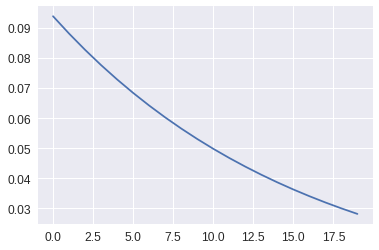

In [131]:
init = tf.global_variables_initializer()

n_epochs = 20
batch_size = 200

learning_rates = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        learning_rates.append(learning_rate.eval(feed_dict={X: X_valid, y: y_valid}))
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val, "learning rate: ", learning_rates[-1])
        
plt.plot(learning_rates)
plt.show()

## 11.4 과대적합을 피하기 위한 규제 방법

DNN 은 수만, 수백반개의 파라미터를 가짐 --> 매우 높은 자유도 --> +: 복잡한 데이터셋 학습 가능 / -: Overfitting 위험



1. 조기 종료
2. $\ell_1$ 과 $\ell_2$ 규제



### 11.4.2 조기 종료 (Early Stopping)

검증 세트의 성능이 떨어지기 시작할 때 훈련 중지

일정한 간격(예를 들면 50 스텝마다) 검증 세트로 모델 평가하여 이전의 최고 성능보다 더 나을 경우 이를 최고 성능의 스냅샷으로 저장하고,

마지막 스냅샷이 저장된 이후 경과한 스텝이 threshold 를 넘으면 (최고 성능 스냅샷이 저장된 후 일정 스텝 경과 후) 훈련 종료

실전에서 잘 작동함!



### 11.4.2 $\ell_1$ 과 $\ell_2$ 규제

$\ell_1$ 과 $\ell_2$ 규제를 연결 가중치에 제약 (bias 에는 적용하지 않음)

참고: http://nbviewer.jupyter.org/github/ExcelsiorCJH/Hands-On-ML/blob/master/Chap04-Training_Models/Chap04-Training_Models.ipynb#4.5-%EA%B7%9C%EC%A0%9C(Regularization)%EA%B0%80-%EC%9E%88%EB%8A%94-%EC%84%A0%ED%98%95-%EB%AA%A8%EB%8D%B8

비용 함수에 적절한 규제항을 추가



In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

그 다음, 층의 가중치에 대한 핸들을 얻어 크로스 엔트로피 손실에 $\ell_1$ 손실(즉, 가중치의 절댓값)을 더해 전체 손실을 계산합니다:

In [0]:
### 각 레이어의 가중치 (/kernel)
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 규제 하이퍼파라미터

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    ### 
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

나머지는 동일

In [134]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_regulation_final.ckpt")

0 검증 세트 정확도: 0.831
1 검증 세트 정확도: 0.871
2 검증 세트 정확도: 0.8838
3 검증 세트 정확도: 0.8934
4 검증 세트 정확도: 0.8966
5 검증 세트 정확도: 0.8988
6 검증 세트 정확도: 0.9016
7 검증 세트 정확도: 0.9044
8 검증 세트 정확도: 0.9058
9 검증 세트 정확도: 0.906
10 검증 세트 정확도: 0.9068
11 검증 세트 정확도: 0.9054
12 검증 세트 정확도: 0.907
13 검증 세트 정확도: 0.9084
14 검증 세트 정확도: 0.9088
15 검증 세트 정확도: 0.9064
16 검증 세트 정확도: 0.9066
17 검증 세트 정확도: 0.9066
18 검증 세트 정확도: 0.9066
19 검증 세트 정확도: 0.9052


레이어마다 이런 형태로 구현하는 것은 복잡함

다른 방법으로는 `tf.layers.dense()` 함수에 규제 함수를 전달할 수 있습니다. 이 함수는 규제 손실을 계산하기 위한 연산을 만들고 규제 손실 컬렉션에 이 연산을 추가합니다. 모델 선언부는 이전과 동일합니다:

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

그다음, 동일한 매개변수를 매번 반복하지 않으려고 파이썬의 `partial()` 함수를 사용합니다. `kernel_regularizer` 매개변수를 지정해야 합니다:

In [0]:
scale = 0.001

from functools import partial

### partial 함수로 각 layer 선언. kernel_regularizer 추가!
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

기본 손실에 규제 손실을 추가합니다:

In [0]:
with tf.name_scope("loss"):                                     # 책에는 없음
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # 책에는 없음
        labels=y, logits=logits)                                # 책에는 없음
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # 책에는 없음
    ### 규제 손실 Regularization Loss
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    ### 전체 손실에 규제 손실 추가
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

나머지는 동일

In [138]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_regularization2_final.ckpt")

0 검증 세트 정확도: 0.8274
1 검증 세트 정확도: 0.8766
2 검증 세트 정확도: 0.8952
3 검증 세트 정확도: 0.9016
4 검증 세트 정확도: 0.9082
5 검증 세트 정확도: 0.9096
6 검증 세트 정확도: 0.9126
7 검증 세트 정확도: 0.9154
8 검증 세트 정확도: 0.9178
9 검증 세트 정확도: 0.919
10 검증 세트 정확도: 0.92
11 검증 세트 정확도: 0.9224
12 검증 세트 정확도: 0.9212
13 검증 세트 정확도: 0.9228
14 검증 세트 정확도: 0.9224
15 검증 세트 정확도: 0.9216
16 검증 세트 정확도: 0.9218
17 검증 세트 정확도: 0.9228
18 검증 세트 정확도: 0.9216
19 검증 세트 정확도: 0.9214


### 11.4.3 Dropout (제외)

ref. (Hinton, Srivastava, Krizhevsky, Sutskever, & Salakhutdinov, 2012), (Srivastava, Hinton, Krizhevsky, Sutskever, & Salakhutdinov, 2014)

매 훈련 스텝에서 각 뉴런(입력 뉴런은 포함, 출력 뉴런은 제외)은 임시적으로 드롭아웃될 확률 $p$(드롭아웃 비율 droptou rate, 보통 $50\%$)를 가짐. 
즉, 이번 훈련 스텝에는 완전히 무시되지만, 다음 스텝에는 활성화 가능

![fig 11-9](https://github.com/jonghoonseo/handson-ml/raw/wip/images/deep/fig_11-9.png)


----

#### 왜 Dropout 이 성능을 향상하나?

회사 비유

출근 여부를 동전 던지기 확률로 결정

모든 업무를 한 명이 전담할 수 없음

전문성이 여러 사람에게 분담되어야 하며, 많은 여러 사람과 협력해야 하므로 회사의 유연성이 높아짐

----
드롭아웃으로 훈련된 뉴런은, 이웃한 뉴런에 맞추어 적응될 수 없음

즉, 가능한 한 자기 자신이 유용해져야 함

이런 뉴런들은 몇 개의 입력 뉴런에만 지나치게 의존할 수 없음 -> 모든 입력 뉴런에 주의 기울여야 함 -> 입력값의 작은 변화에 덜 민감 -> 더 안정적인 네트워크

----
각 훈련 스텝마다 고유 네트워크 생성

개별 신경망은 대부분의 가중치를 공유하고 있기 때문에 아주 독립적이지는 않음

결과적으로 만들어진 신경망은 이 모든 신경망을 평균한 앙상블로 볼 수 있음

----

#### 기술적 세부사항

$p = 50\%$ 인 경우

평균적으로 한 뉴런이, 테스트 시에 훈련시보다 두 배 많은 입력 뉴런과 연결됨

이런 점을 보상하기 위해 훈련하고 나서 각 뉴런의 연결 가중치에 0.5를 곱함

##### general rule


훈련 후에 각 입력의 연결 가중치에 keep probability $(1-p)$를 곱해야 함

훈련 중에 각 뉴런의 출력을 keep probability 로 나눔



#### dropout in tensorflow

텐서플로를 사용해 드롭아웃을 구현하려면, `tf.layers.dropout()`함수를 입력층이나 원하는 은닉층의 출력에 적용

훈련 동안 이 함수는 무작위로 **뉴런을 제거**하며 **나머지 출력을 보존 확률로 나눔**

훈련 시에는 `training` 변수를 `True`로, 테스트 시에는 `False`로 지정해야 함

보통 `tf.nn.dropout()` 함수보다 `tf.layers.dropout()` 함수를 더 선호함. 후자는 훈련하지 않을 때 작동하지 않으나, 전자는 훈련하지 않을 때에도 작동함.

In [0]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
training = tf.placeholder_with_default(False, shape=(), name='training')

### define dropout_rate
dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    ### insert dropout layer
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    ### insert dropout layer
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

나머지는 동일

In [141]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./my_model_dropout_final.ckpt")

0 검증 세트 정확도: 0.9254
1 검증 세트 정확도: 0.9452
2 검증 세트 정확도: 0.9492
3 검증 세트 정확도: 0.9566
4 검증 세트 정확도: 0.9618
5 검증 세트 정확도: 0.96
6 검증 세트 정확도: 0.96
7 검증 세트 정확도: 0.9684
8 검증 세트 정확도: 0.9688
9 검증 세트 정확도: 0.9712
10 검증 세트 정확도: 0.9706
11 검증 세트 정확도: 0.9684
12 검증 세트 정확도: 0.9716
13 검증 세트 정확도: 0.972
14 검증 세트 정확도: 0.9724
15 검증 세트 정확도: 0.972
16 검증 세트 정확도: 0.9714
17 검증 세트 정확도: 0.9712
18 검증 세트 정확도: 0.9732
19 검증 세트 정확도: 0.9732


#### 드롭아웃의 적용 팁

- overfitting? -> increase dropout rate
- underfitting? ->decrease dropout rate

- deep network? -> increase dropout rate
- shallow network? -> decrease dropout rate

----
#### 추가 - Dropconnect

드롭아웃의 변종으로, 전체 뉴런이 아니라 개별 연결을 무작위로 끔

일반적으로 드롭아웃의 성능이 더 좋음

### 11.4.4 Max-Norm 규제

각각의 뉴런에 대해 입력의 연결 가중치 $\mathbf{w} $ 가 $\left\| \mathbf{w} \right\|_2 \leq r$이 되도록 제한
- $r$은 맥스-노름 하이퍼파라미터
- $\left\|\cdot \right\|_2$는 $\ell_2$ 노름

매 훈련 스텝이 끝나고 $\left\| \mathbf{w} \right\|_2$ 를 계산한 다음 $\mathbf{w}$를 클리핑 $ \left( \mathbf{w} \gets \mathbf{w} \dfrac{r}{\left\| \mathbf{w} \right\|_2} \right)$ 합니다.

----

$r$을 줄이면 -> 규제 커짐 -> overfitting 감소



#### Max-Norm Regularization in tensorflow

텐서플로에는 내장되어 있지 않음

은닉층의 가중치를 구한 후, `clip_by_norm()` 함수를 사용해 각 행 벡터의 최대 노름이 1.0이 되도록 가중치를 클리핑


In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

다음으로 첫 번째 은닉층의 가중치에 대한 핸들을 얻고 `clip_by_norm()` 함수를 사용해 가중치를 클리핑하는 연산을 만듭니다. 그런 다음 클리핑된 가중치를 가중치 변수에 할당하는 연산을 만듭니다:

In [0]:
threshold = 1.0

# 은닉층 가중치에 대한 핸들 획득
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
# 가중치를 클리핑
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
# 클리핑 된 가중치를 가중치 변수에 다시 할당
clip_weights = tf.assign(weights, clipped_weights)

# 은닉층 가중치에 대한 핸들 획득
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
# 가중치를 클리핑
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
# 클리핑 된 가중치를 가중치 변수에 다시 할당
clip_weights2 = tf.assign(weights2, clipped_weights2)

In [144]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 50

with tf.Session() as sess:                                              # 책에는 없음
    init.run()                                                          # 책에는 없음
    for epoch in range(n_epochs):                                       # 책에는 없음
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):  # 책에는 없음
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            # clip_weights, clip_weights2 를 계산
            clip_weights.eval()
            clip_weights2.eval()                                        # 책에는 없음
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # 책에는 없음
        print(epoch, "검증 세트 정확도:", accuracy_val)                     # 책에는 없음

    save_path = saver.save(sess, "./my_model_max_norm_final.ckpt")               # 책에는 없음

0 검증 세트 정확도: 0.9568
1 검증 세트 정확도: 0.9696
2 검증 세트 정확도: 0.9722
3 검증 세트 정확도: 0.977
4 검증 세트 정확도: 0.977
5 검증 세트 정확도: 0.9772
6 검증 세트 정확도: 0.9818
7 검증 세트 정확도: 0.9824
8 검증 세트 정확도: 0.9806
9 검증 세트 정확도: 0.9826
10 검증 세트 정확도: 0.9826
11 검증 세트 정확도: 0.9836
12 검증 세트 정확도: 0.9828
13 검증 세트 정확도: 0.9838
14 검증 세트 정확도: 0.9848
15 검증 세트 정확도: 0.9846
16 검증 세트 정확도: 0.9842
17 검증 세트 정확도: 0.9846
18 검증 세트 정확도: 0.985
19 검증 세트 정확도: 0.985


위 구현은 이해하기 쉽고 잘 작동하지만 조금 번거롭습니다. 더 나은 방법은 `max_norm_regularizer()` 함수를 만드는 것입니다:

In [0]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # 규제 손실을 위한 항이 없습니다
    return max_norm

그런 다음 (필요한 임계값을 지정해서) 맥스 노름 규제 매개변수에 넘길 함수를 만들기 위해 이 함수를 호출합니다. 은닉층을 만들 때 이 규제 함수를 `kernel_regularizer` 매개변수를 통해 전달할 수 있습니다:

In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    # kernel_regularizer = max_norm_reg 로 규제함수 전달
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [0]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 50

In [149]:
# max_norm 들에 대한 collection
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            # max_norm collection 실행
            sess.run(clip_all_weights)
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # 책에는 없음
        print(epoch, "검증 세트 정확도:", accuracy_val)                      # 책에는 없음

    save_path = saver.save(sess, "./my_model_max_norm2_final.ckpt")                # 책에는 없음

0 검증 세트 정확도: 0.9556
1 검증 세트 정확도: 0.9702
2 검증 세트 정확도: 0.9694
3 검증 세트 정확도: 0.9734
4 검증 세트 정확도: 0.9776
5 검증 세트 정확도: 0.9758
6 검증 세트 정확도: 0.9806
7 검증 세트 정확도: 0.9812
8 검증 세트 정확도: 0.9832
9 검증 세트 정확도: 0.9826
10 검증 세트 정확도: 0.9818
11 검증 세트 정확도: 0.9828
12 검증 세트 정확도: 0.9828
13 검증 세트 정확도: 0.9836
14 검증 세트 정확도: 0.9838
15 검증 세트 정확도: 0.984
16 검증 세트 정확도: 0.9832
17 검증 세트 정확도: 0.9838
18 검증 세트 정확도: 0.9844
19 검증 세트 정확도: 0.9844


### 11.4.5 Data Augmentation

기존의 데이터에서 새로운 데이터를 생성해 인공적으로 훈련 세트의 크기를 늘림

이상적으로는 사람이 인공적으로 만든 샘프인지 아닌지 구분할 수 없어야 함

단순한 white noise 를 추가하는 것은 도움이 되지 않음

예) transpose, rotate, resize, flip, crop

## 11.5 실용적 가이드라인

기본 DNN 설정

| 항목 | 알고리즘 |
|---|---|
| 초기화 | He Initialization |
| 활성화 함수 | ELU |
| 정규화 | Batch Normalization |
| 규제 | Dropout |
| 옵티마이저 | Nesterov Accelerated Gradient(NAG) |
|학습률 스케쥴링 | N/A |

다음 경우에는 위의 설정 변경 필요

- 좋은 learning rate를 찾을 수 없을 때 ==> 지수 감소 같은 [학습 스케쥴](https://colab.research.google.com/drive/155vfvxdnEEeq-nvBrGYgx2_FEWBllpXt#scrollTo=ByIBlR68RZ46) 추가
- 훈련 세트가 너무 작으면 ==> [Data Augmentation](https://colab.research.google.com/drive/155vfvxdnEEeq-nvBrGYgx2_FEWBllpXt#scrollTo=ipPbql6s21rL&line=9&uniqifier=1)
- Sparse 모델이 필요하면 ==> [$\ell_1$ 규제](https://colab.research.google.com/drive/155vfvxdnEEeq-nvBrGYgx2_FEWBllpXt#scrollTo=PMIBLYvBowpw) 추가
- 실행 속도가 아주 빠른 모델 필요하면 ==> Batch Normalization 제거, ELU 대신 [LeakyReLU](https://colab.research.google.com/drive/155vfvxdnEEeq-nvBrGYgx2_FEWBllpXt#scrollTo=S4Hp5UOeAQPb)로 변경, Sparse 모델 생성



### References

(Hinton, Srivastava, Krizhevsky, Sutskever, & Salakhutdinov, 2012) Hinton, G. E., Srivastava, N., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. R. (2012). Improving neural networks by preventing co-adaptation of feature detectors. Retrieved (으)로부터 https://arxiv.org/abs/1207.0580

(Srivastava, Hinton, Krizhevsky, Sutskever, & Salakhutdinov, 2014) Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Journal of Machine Learning Research, 15, 1929–1958.

